In [24]:
# %pip install graphviz
# %pip install pydot --upgrade
# %pip install pydotplus --upgrade

In [25]:
from pathlib import Path
import imghdr
import os

data_dir = "/hair_types"
image_extensions = [".png", ".jpg"] # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="training",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="validation",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)


Found 987 files belonging to 3 classes.
Using 889 files for training.
Found 987 files belonging to 3 classes.
Using 98 files for validation.


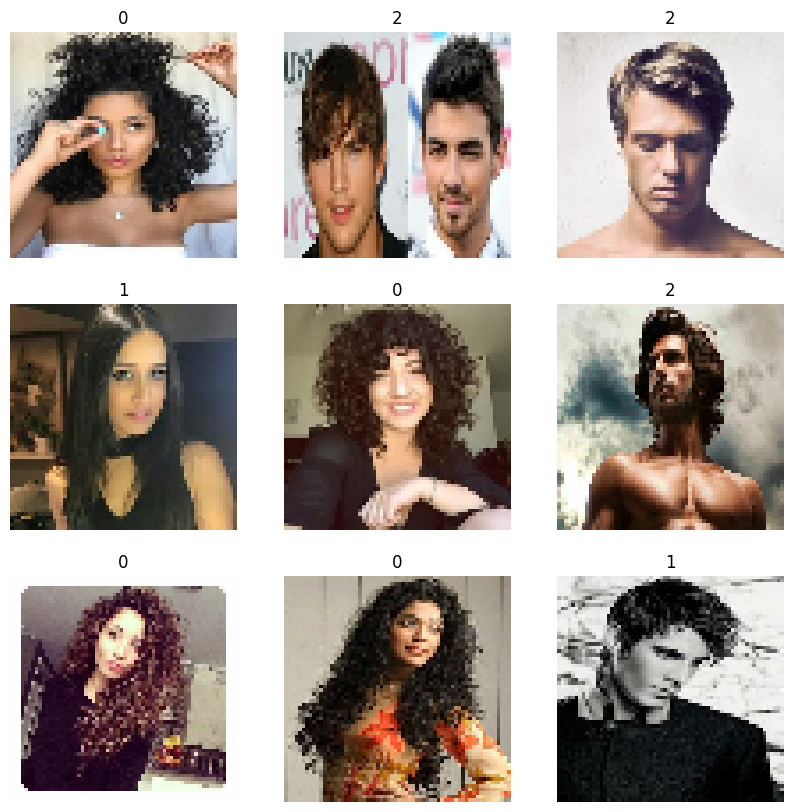

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

In [28]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_ds.prefetch(tf_data.AUTOTUNE)
val_dataset = val_ds.prefetch(tf_data.AUTOTUNE)

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband
from tensorflow.keras.layers import SpatialDropout2D


# Define the model-building function

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=image_size + (3,)))
    model.add(layers.Rescaling(1.0 / 255))
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))

    # Tune the number of filters and kernel size for each convolutional layer
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)): # Tune the number of convolutional layers
        model.add(layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=4, max_value=16, step=4), # Tune the number of filters
            kernel_size=hp.Choice('kernel_size_' + str(i), values=[4, 8, 16]), # Tune the kernel size
            strides=1,
            padding='valid',
            dilation_rate=1,
            kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_reg', values=[0.0, 1e-3, 1e-4, 1e-5])) # Add L2 regularization
        ))
        model.add(layers.Activation("relu")) # Add ReLU activation function
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2)) # Add max pooling layer
        model.add(SpatialDropout2D(hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3])))

    model.add(layers.GlobalAveragePooling2D()) # Add global average pooling layer

    # Add more layers for complexity
    for _ in range(hp.Int('num_dense_layers', min_value=1, max_value=3)): # Tune the number of dense layers
        model.add(layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

    model.add(layers.Dense(3, activation='softmax'))
    # Define the optimizer choices
    #optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    # if optimizer_choice == 'adam':
    #     optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    # elif optimizer_choice == 'rmsprop':
    #     optimizer = keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    # elif optimizer_choice == 'sgd':
    #     optimizer = keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    # Compile the model with the specified optimizer
    model.compile(
        optimizer= keras.optimizers.AdaBelief(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


from datetime import datetime
import os

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a unique project name by appending the current date and time
project_name = f"hair_prediction_{current_time}"

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='keras_tuner',
    project_name= 'hair_prediction_3'
)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=20, validation_data=val_ds)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



Reloading Tuner from keras_tuner\hair_prediction_3\tuner0.json


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [30]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 61, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 61, 61, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 12)     │         1,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 27, 27, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 4)        │         3,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6, 6, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,275 (20.61 KB)

 Trainable params: 5,275 (20.61 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Assuming 'tuner' is your Keras Tuner object
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Create a table header
print(f"{'Parameter':<25} | {'Value'}")

# Separator for clarity
print("-" * 40)

# Iterate over the hyperparameters and print them
for hp_name in best_hyperparameters.values:
    print(f"{hp_name:<25} | {best_hyperparameters.get(hp_name)}")

Parameter                 | Value
----------------------------------------
num_conv_layers           | 3
filters_0                 | 8
kernel_size_0             | 4
l2_reg                    | 0.0001
spatial_dropout           | 0.2
num_dense_layers          | 1
units                     | 32
learning_rate             | 0.001
filters_1                 | 12
kernel_size_1             | 4
filters_2                 | 4
kernel_size_2             | 8
tuner/epochs              | 50
tuner/initial_epoch       | 17
tuner/bracket             | 2
tuner/round               | 2
tuner/trial_id            | 0056


In [32]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense


# model = Sequential()

# model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
# model.add(layers.Rescaling(1.0 / 255))
# #model.add(layers.RandomFlip("horizontal"))
# #model.add(layers.RandomRotation(0.1))


# model.add(layers.Conv2D(filters=16, kernel_size=16, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# model.add(layers.Conv2D(filters=4, kernel_size=8, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
# model.add(layers.SpatialDropout2D(0.5))

# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(32))
# model.add(layers.Activation("relu"))
# model.add(layers.Dense(3))
# model.add(layers.Activation("softmax"))

# #keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# model.compile(
#  optimizer=keras.optimizers.Adam(1e-3),
#  loss="categorical_crossentropy",
#  metrics=["accuracy"],
# )



Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5335 - loss: 0.9193 - val_accuracy: 0.5408 - val_loss: 0.9903
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5865 - loss: 0.8668 - val_accuracy: 0.5816 - val_loss: 0.9333
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5963 - loss: 0.8568 - val_accuracy: 0.6020 - val_loss: 0.9042
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5722 - loss: 0.8681 - val_accuracy: 0.5306 - val_loss: 1.0932
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5692 - loss: 0.8817 - val_accuracy: 0.5612 - val_loss: 0.9585
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5704 - loss: 0.8618 - val_accuracy: 0.6224 - val_loss: 0.8463
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5536 - loss: 0.8993 - val_accuracy: 0.6020 - val_loss: 0.8527
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5678 - loss: 0.8685 - val_accuracy: 0.

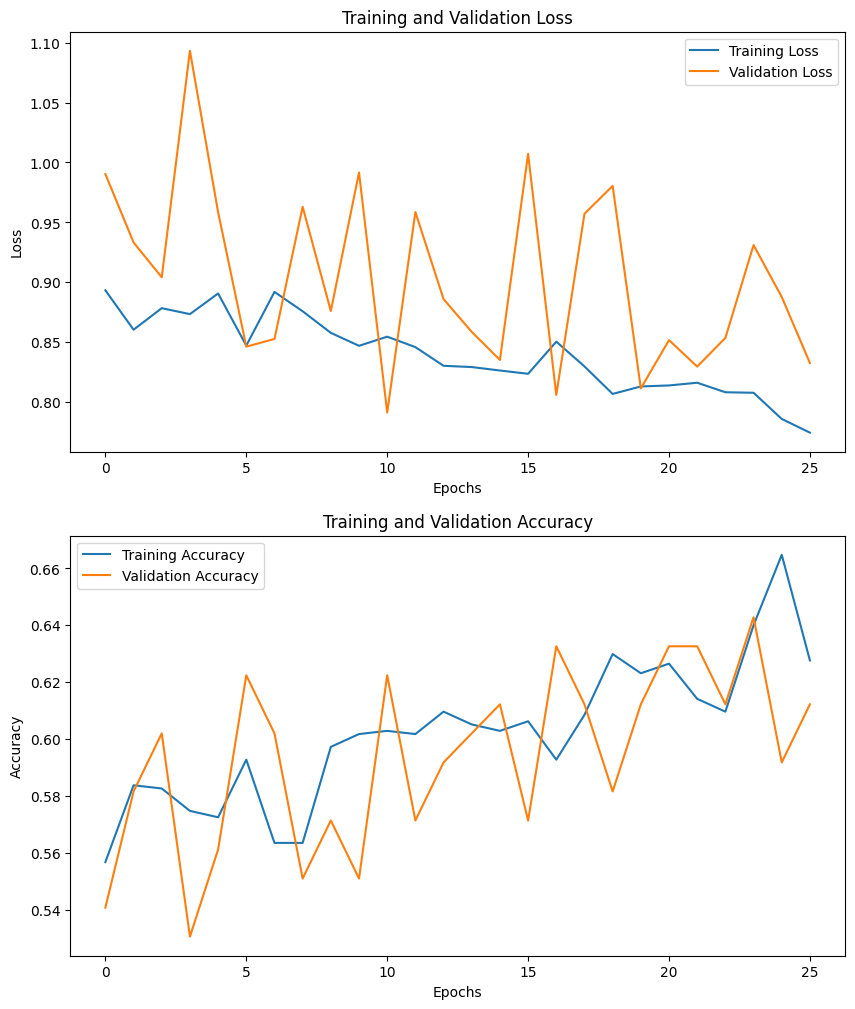

In [33]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

epochs = 150

# Assuming train_ds and val_ds are defined and the model is compiled
history = best_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[EarlyStopping(patience=15)])
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


# Creates a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Show the combined graph
plt.show()




In [36]:

# Evaluate the best model
totaltrain_accuracy = 0
totaltrain_loss = 0

num_iterations = 10



for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(train_ds)
    totaltrain_accuracy += accuracy
    totaltrain_loss += loss


average_accuracy = totaltrain_accuracy / num_iterations
average_loss = totaltrain_loss / num_iterations
print("Average Training Accuracy:", average_accuracy)
print("Average Training Loss:", average_loss)

totalval_accuracy = 0
totalval_loss = 0
for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(val_ds)
    totalval_accuracy += accuracy
    totalval_loss += loss


average_accuracy = totalval_accuracy / num_iterations
average_loss = totalval_loss / num_iterations
print("Average Validation Accuracy:", average_accuracy)
print("Average Validation Loss:", average_loss)





28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6728 - loss: 0.6997
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6587 - loss: 0.7128
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6759 - loss: 0.7017
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6668 - loss: 0.7080
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6739 - loss: 0.7113
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6619 - loss: 0.7173
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6698 - loss: 0.7234
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6557 - loss: 0.7207
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6806 - loss: 0.6977
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6658 - loss: 0.7005
Average Training Accuracy: 0.6782901883125305
Average Training Loss: 0.7064105808734894
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6397 - loss: 0.7950 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6241 - loss: 0.8112 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [35]:
img = keras.preprocessing.image.load_img(
"8126fdb0-ab66-4c49-a85c-f100bc12966a.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = best_model.predict(img_array)
print(
 "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
 % tuple(predictions[0])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
This image is 0.63 percent curly hair, 0.26 percent straight hair, and 0.11 percent wavy hair.
